<a href="https://colab.research.google.com/github/sasso-effe/spotify-hit-predictor/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Bayesian Network to predict if a song of Spotify will be an hit or not

## Data and preprocessing
The dataset is taken from [Kaggle - Hit song science - 34740 songs (+spotify features)](https://www.kaggle.com/multispiros/34740-hit-and-nonhit-songs-spotify-features).

This dataset contains 34740 entries represented songs. Each entry has the following fields:
 - **artist_name**: the name of the artist;
 - **danceability**: how suitable the track is for dancing based on a combination of musical elements. 0.0 is least danceable, while 1.0 is most danceable;
 - **energy**: a perceptual measurity of intensity and activity based on dynamic range, perceived loudness, timbre, onset rate and general entropy. 0.0 is least energic, while 1.0 is most energic;
 - **key**: the estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.
 - **loudness**: the overall loudness of the track in decibels;
 - **mode**: indicate if the track is in minor (0) or major (1) modality;
 - **speechiness**: the presence of spoken words in a track. 1.0 is a track made entirely of spoken words, while 0.0 is a track without spoken words;
 - **acousticness**: a confidence measure of whether the track is acoustic. 0.0 is least confidence, 1.0 is most confidence;
 - **instrumentalness**: a confidence measure of wheter the track contains no vocal. 0.0 is least confidence, 1.0 is most confidence;
 - **liveness**: a confidence measure of wheter the track was performed live. 0.0 is least confidence, 1.0 is most confidence;
 - **valence**: a perceptual measurity of the musical positiviness of the track. 0.0 is the most negative (angry, sad) song, while 1.0 is the most positive (happy, cheerful) one;
 - **tempo**: the overall estimated tempo of yhr track in beats per minute (BPM);
 - **duration_ms**: the duration of the track in milliseconds;
 - **On_chart**: 1 for hit (songs that have been at least one time on the 100 position charts), 0 for non-hit;

and also other features which are not used in this project because reputed irrelevant.

The database is oversampled, since the number of hit and non hit is almost the same, while in the reality there are more non-hit songs than hit songs. However this is not a big deal for this project, since even if we should have general higher probabilities for a song to be an hit, we are still be able to see which features are more important than others.

## Preprocessing
Before constructing the network we need to preprocess the data according to the following steps:
 1. Remove all the useless feature (i.e. the ones not listed above);
 2. Disretize continuous features, since pmgpy does not support continuous variables
 3. Make the features range smaller, to reduce the RAM needed by pgmpy to generate the network. This can be done by transform values in deciles.


In [1]:
pip install pgmpy

In [2]:
import sys
import os

%cd /content
!rm -rf spotify-hit-predictor &> /dev/null
!git clone https://github.com/sasso-effe/spotify-hit-predictor &> /dev/null
%cd spotify-hit-predictor
sys.path.append(os.getcwd())

/content
/content/spotify-hit-predictor


In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv("songs_db.csv")
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Dataset contains 34740 rows and 17 columns


,track_title,artist_name,track_id,duration_ms,energy,key,mode,time_signature,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart
0,Red Planet - Red Planet Radio,Joe,3FeufAV1f6fajILIQuAXMw,256080,0.96800,7,0,4,0.02150,0.698,0.862000,0.1110,-11.012,0.0337,0.3900,136.884,0
1,Red Planet - Red Planet Extended,Joe,2o7oYjZuo3S2QitY4R5dII,395442,0.97000,2,1,4,0.00339,0.724,0.896000,0.1060,-8.415,0.0358,0.4320,136.868,0
2,Basejump,Robin Schulz,6nWoNNkfffbmHU9z3kGPao,391680,0.40600,5,0,4,0.00433,0.803,0.825000,0.0948,-9.444,0.0608,0.0769,125.014,0
3,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,5Zg1UOcmee5oiRw3gbXna0,347840,0.00267,7,0,5,0.91000,0.150,0.028700,0.1250,-24.701,0.0434,0.1050,135.652,0
4,"Goldberg Variations, BWV 988 (Arr. for Accordi...",Johann Sebastian Bach,2ZWmWGoZS2OTGZSnMhck7Q,181733,0.22600,7,1,4,0.76800,0.290,0.000002,0.1050,-14.990,0.0385,0.4700,98.348,0


In [5]:
data = df.drop(columns=['track_title', 'track_id', 'time_signature', 'artist_name']).dropna()

# discretization
for col in ['energy', 'acousticness', 'danceability', 'speechiness', 'valence']:
            data[col] = data[col].apply(lambda x: int(round(x*5, 0)))
for col in ['tempo', 'loudness']:
  data[col] = data[col].apply(int)
data['instrumentalness'] = data['instrumentalness'].apply(lambda x: 0 if x<=0.5 else 1)
data['liveness'] = data['liveness'].apply(lambda x: 0 if x<=0.8 else 1)

# Transformation in deciles
for col in ('loudness', 'tempo', 'duration_ms'):
    bins = pd.qcut(data[col], q=5, duplicates='drop')
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)

In [6]:
print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns')
data.head()

Dataset contains 34740 rows and 13 columns


,duration_ms,energy,key,mode,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,valence,tempo,On_chart
0,3,5,7,0,0,3,1,0,1,0,2,3,0
1,4,5,2,1,0,4,1,0,2,0,2,3,0
2,4,2,5,0,0,4,1,0,1,0,0,2,0
3,4,0,7,0,5,1,0,0,0,0,1,3,0
4,1,1,7,1,4,1,0,0,0,0,2,1,0


## Network definition

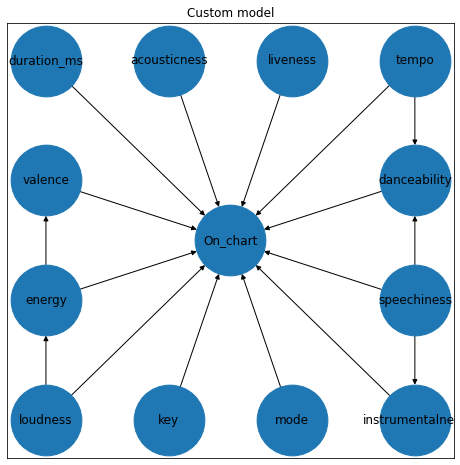

In [7]:
custom_model = BayesianModel([('tempo', 'danceability'), ('loudness', 'energy'),
                              ('speechiness', 'danceability'), ('speechiness', 'instrumentalness'),
                              ('energy', 'valence'),
                              ('duration_ms', 'On_chart'), ('energy', 'On_chart'),
                              ('key', 'On_chart'), ('mode', 'On_chart'),
                              ('acousticness', 'On_chart'), ('danceability', 'On_chart'),
                              ('instrumentalness', 'On_chart'), ('liveness', 'On_chart'),
                              ('loudness', 'On_chart'), ('speechiness', 'On_chart'),
                              ('valence', 'On_chart'), ('tempo', 'On_chart')])
pos = {'duration_ms': [-1.5, 2], 'acousticness': [-0.5, 2], 'liveness': [0.5, 2], 'tempo': [1.5,  2],
       'valence': [-1.5,  1.5], 'energy': [-1.5, 1], 'loudness': [-1.5, 0.5],
       'danceability': [1.5, 1.5], 'speechiness': [1.5,  1], 'instrumentalness': [1.5, 0.5],
       'On_chart': [0, 1.25],
       'key': [-0.5, 0.5], 'mode': [0.5, 0.5]}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')

This network sums up our knowledge about the data: every feature potentially influence if a track will be a hit, and not the contrary. Also, according to Spotify API, danceability is caused by tempo and energy is caused by loudness. We can also state that the valence is caused by energy, that the daceability is caused by speechiness (a podcast is not danceable) and also instrumentalness is influenced by speechiness.

The problem with this network is that is too complex to calculate the weights. According to pgmpy it should requires to allocate an anrray of 3200 TB, so we will try with other solutions.

## Learning the network structure

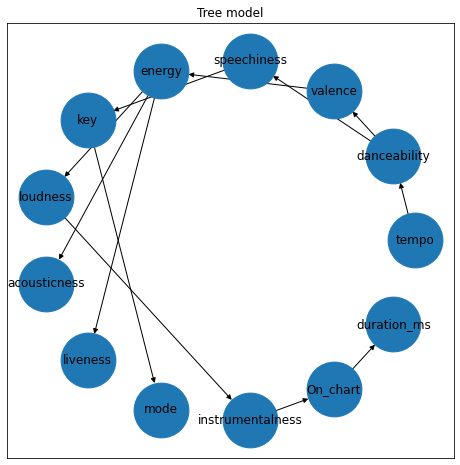

In [8]:
ts = TreeSearch(data=data, root_node='tempo')
tree_model = ts.estimate(show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3000)
fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

The tree serach is an easy way to generate a network, but due to the nature of the problem, wgich makes difficoult to choose a root, it does not return good results. Changing the root we obtain similar results, so we need more complex algorithms, like HillCLimb Search.

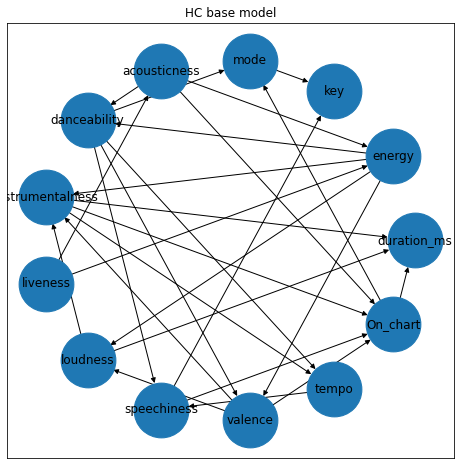

In [9]:
scorer = BDeuScore(data=data)
hc = HillClimbSearch(data=data)
hc_base_model = hc.estimate(scoring_method=scorer, show_progress=False)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.circular_layout(hc_base_model), ax=ax, node_size=3000)
fig.savefig('hc_base')
ax.set_title('HC base model')
hc_base_model = BayesianModel(hc_base_model.edges())

This is of course a more complex network, but there are some problems:
On_chart cannot be a contributor factor to anyone of the other features, since at first a track is made, with all its features, and only then it becomes a hit or not.

Another problem is that the dependendence tempo -> danceability we know to be true is missing.

All these problems will be solved applying some constraints. Unfortunately pgmpy requires too much RAM to generate this model, so we remove some features that from the previous graph seem to bee less influents: liveness


In [10]:
data_small = data.drop(columns=['liveness'])

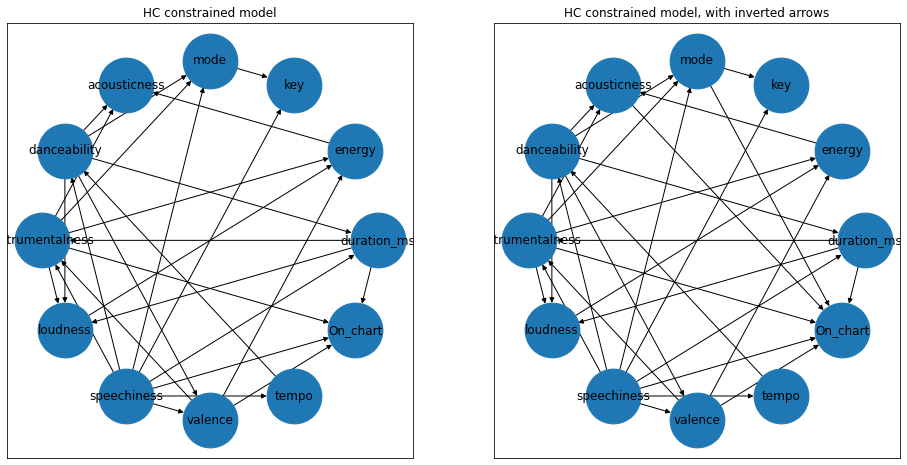

In [11]:
fixed_edges = [('tempo', 'danceability'), ('loudness', 'energy')]

# On_chart cannot be the cause of anything
black_list = [('On_chart', c) for c in data_small.columns]

scorer = BDeuScore(data=data_small)
hc = HillClimbSearch(data=data_small)
hc_constr_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fixed_edges += [(c, 'On_chart') for c in ['valence', 'speechiness', 'instrumentalness', 'acousticness', 'mode', 'duration_ms']]
hc_inv_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list, show_progress=False)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
nx.draw_networkx(hc_constr_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax[0], node_size=3000)
nx.draw_networkx(hc_inv_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax[1], node_size=3000)
ax[0].set_title('HC constrained model')
ax[1].set_title('HC constrained model, with inverted arrows')

hc_constr_model = BayesianModel(hc_constr_model.edges())
hc_inv_model = BayesianModel(hc_inv_model.edges())




In [12]:
# The custom one requires to RAM, so it is omitted
# Also, the tree model seems inaccurate, so it is omitted, too
hc_base_model.fit(data, estimator=MaximumLikelihoodEstimator)
hc_constr_model.fit(data_small, estimator=MaximumLikelihoodEstimator)
hc_inv_model.fit(data_small, estimator=MaximumLikelihoodEstimator)

In [13]:
models = [{'name': 'HC base model', 'model': hc_base_model, 'nodes': data.columns.values.tolist()},
          {'name': 'HC constraint model', 'model': hc_base_model, 'nodes': data_small.columns.values.tolist()},
          {'name': 'HC constraint model, with inverted arrows', 'model': hc_base_model, 'nodes': data_small.columns.values.tolist()}]

In [15]:
for model in models:
  print('Considering model:', model['name'])
  print('Considering nodes:', model['nodes'])
  print(f"The total number of valid independence assertions is {len(model['model'].get_independencies().get_assertions())}")
  print(f"Local semantics of the current model:\n{model['model'].local_independencies(model['nodes'])}")
  print('Checking Markov blankets')
  for node in model['nodes']:
    print(f"The Markov blanket of node {node} is {model['model'].get_markov_blanket(node)}")
  print()

Considering model: HC base model
Considering nodes: ['duration_ms', 'energy', 'key', 'mode', 'acousticness', 'danceability', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'On_chart']
The total number of valid independence assertions is 20528
Local semantics of the current model:
(duration_ms ⟂ valence, mode, tempo, liveness, key, energy, acousticness, danceability, speechiness | On_chart, instrumentalness, loudness)
(key ⟂ valence, tempo, duration_ms, liveness, energy, loudness, acousticness, On_chart, danceability, instrumentalness | speechiness, mode)
(mode ⟂ valence, tempo, duration_ms, liveness, energy, loudness, acousticness, instrumentalness, speechiness | On_chart, danceability)
(danceability ⟂ liveness | energy, acousticness)
(instrumentalness ⟂ liveness, danceability, acousticness | valence, energy, loudness)
(loudness ⟂ liveness, danceability, acousticness | valence, energy)
(speechiness ⟂ valence, instrumentalness, energy, liveness, loudness,

## Performing inferences

In [16]:
inferences = {}
for model in models:
  inferences[model['name']] = VariableElimination(model['model'])

### Base model

In the base model the features that directly influence On_chart are:
 - acousticness, range {0,...,4},
 - instrumentalness, range {0,1},
 - speechiness, range {0,...,4},
 - valence, range {0,...,4}.

Let's see how they influence it.

In [17]:
ve = inferences['HC base model']
answers_acoustic = []
answers_instrumental = []
answers_speech = []
answers_valence = []
for score in range(5):
  for feature, answers in [('acousticness', answers_acoustic),
                            ('speechiness', answers_speech),
                            ('valence', answers_valence)]:
    evidence = {feature : score}
    answers.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])
for score in range(2):
  evidence = {"instrumentalness": score}
  answers_instrumental.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])

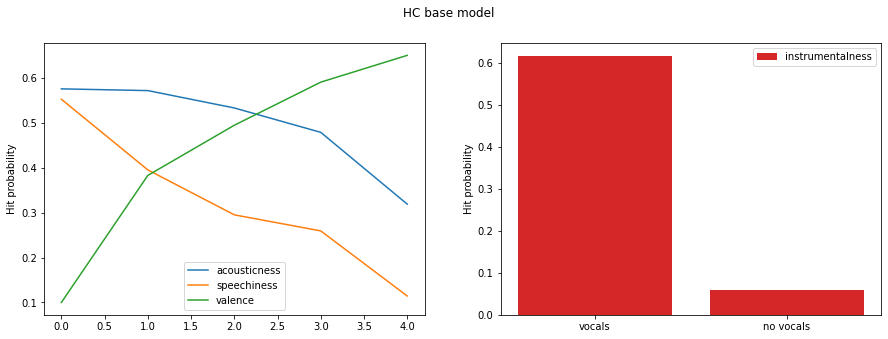

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"HC base model")
ax.set_ylabel('Hit probability')
ax.plot(answers_acoustic, label='acousticness')
ax.plot(answers_speech, label='speechiness')
ax.plot(answers_valence, label='valence')
ax.legend()
ax2 =axes[1]
ax2.bar(range(2), answers_instrumental, label='instrumentalness', color='C3')
ax2.legend()
ax2.set_xticks(range(2))
ax2.set_xticklabels(['vocals', 'no vocals'])
ax2.set_ylabel('Hit probability')
fig.savefig('query1')

Instrumentalness seems to have a huge impact: tracks with no vocals have less than 10% probability of be hits.

Speechiness has also an important role, and this was quite expected, since according to Spotify documentation a song should have a speechiness value between 0 and 0.33 (0 and 2 after preproccessing), with the exceptions of rap songs which span between 0.33 and 0.66 (2 and 3). Tracks above 0.66 are that are probably made entirely of spoken words, like podcasts.

We can also see that non-acoustic tracks have higher probabilities, but it seems to be the less impactant factor.

While valence is very relevant, with negative songs having almost no chance.

Now, what happens if we fix that our track has vocals?

In [25]:
answers = [[[] for _ in range(5)] for _ in range(5)]
for valence in range(5):
  for acousticness in range(5):
    for speechiness in range(5):
      evidence = {"acousticness": acousticness, "speechiness": speechiness, 'instrumentalness': 0, 'valence': valence}
      answers[valence][acousticness].append(ve.query(["On_chart"], evidence, show_progress=False).values[1])

In [26]:
def plot3d(X, Y, Z, xlabel, ylabel, zlabel, title):
  fig = plt.figure(figsize=(15, 5))
  fig.suptitle(title)
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  X, Y = np.meshgrid(X, Y)
  ax.plot_surface(X, Y, Z, rstride=1, cstride=1, edgecolor='white', cmap='viridis')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_zlabel(zlabel)
  ax = fig.add_subplot(1,2,2)
  CS = ax.contour(Z)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.clabel(CS, inline=True, fontsize=10)
  plt.show()

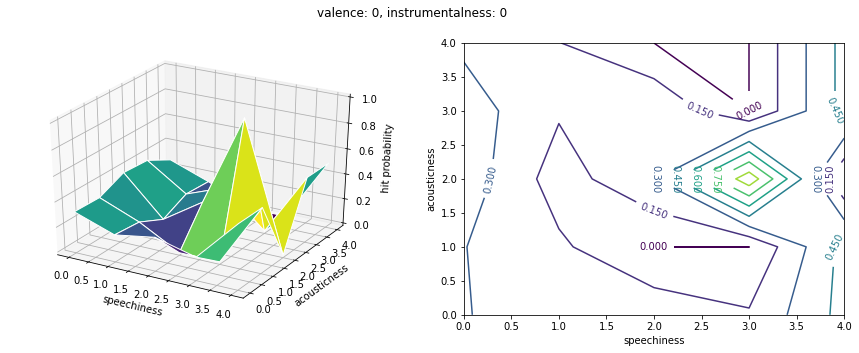

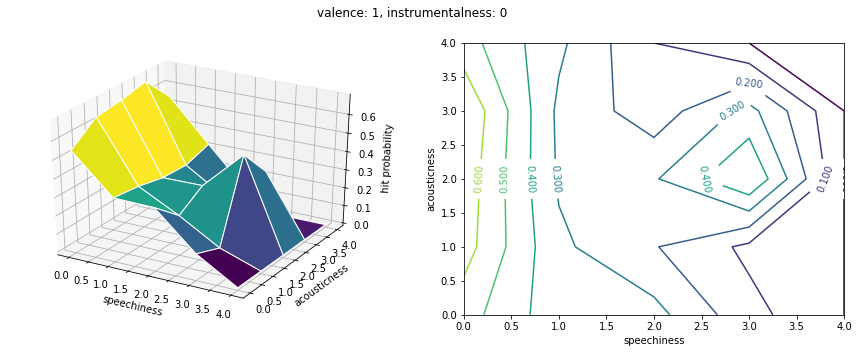

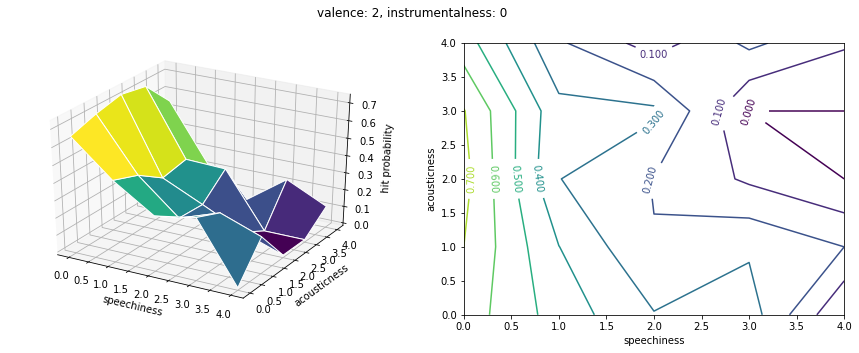

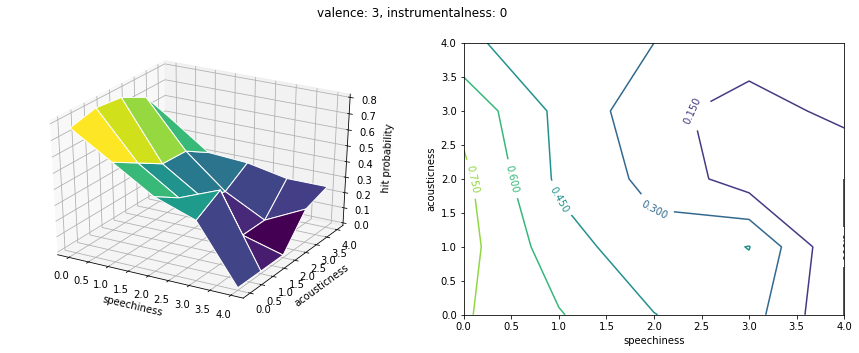

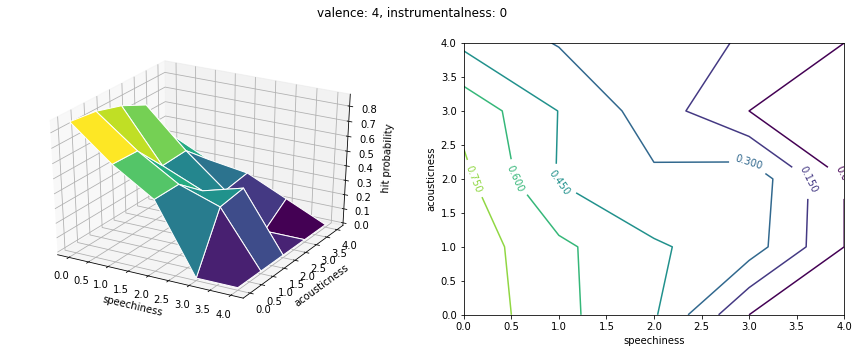

In [27]:
for i in range(5):
  plot3d(range(5), range(5), np.array(answers[i]),
         'speechiness', 'acousticness', 'hit probability', f'valence: {i}, instrumentalness: 0')

We can observe a courious beahviour: sad or angry songs (valence 0) have higher probabilities when the speechiness is 3, which sholud corresponds to rap songs, and the acousticness is 2

### HC constrained model

In the base model the features that directly influence On_chart are:
 - duration_ms, range {0,...,4},
 - instrumentalness, range {0,1},
 - speechiness, range {0,...,4},
 - valence, range {0,...,4}.

Let's see how they influence it.

In [28]:
ve = inferences['HC constraint model']
answers_duration = []
answers_instrumental = []
answers_speech = []
answers_valence = []
for score in range(5):
  for feature, answers in [('duration_ms', answers_duration),
                            ('speechiness', answers_speech),
                            ('valence', answers_valence)]:
    evidence = {feature : score}
    answers.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])
for score in range(2):
  evidence = {"instrumentalness": score}
  answers_instrumental.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])

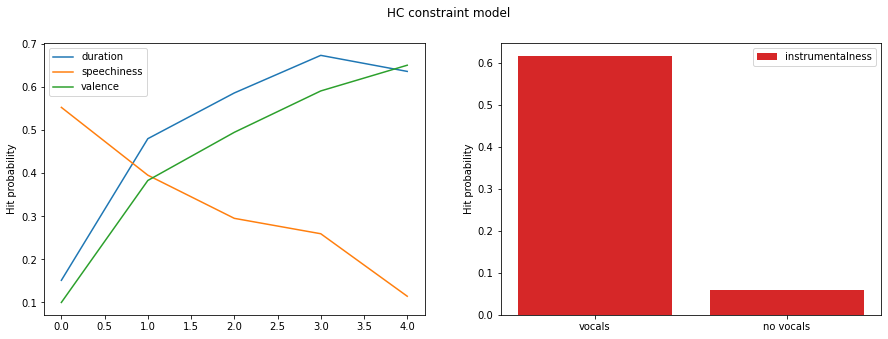

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"HC constraint model")
ax.set_ylabel('Hit probability')
ax.plot(answers_duration, label='duration')
ax.plot(answers_speech, label='speechiness')
ax.plot(answers_valence, label='valence')
ax.legend()
ax2 =axes[1]
ax2.bar(range(2), answers_instrumental, label='instrumentalness', color='C3')
ax2.legend()
ax2.set_xticks(range(2))
ax2.set_xticklabels(['vocals', 'no vocals'])
ax2.set_ylabel('Hit probability')
fig.savefig('query1')

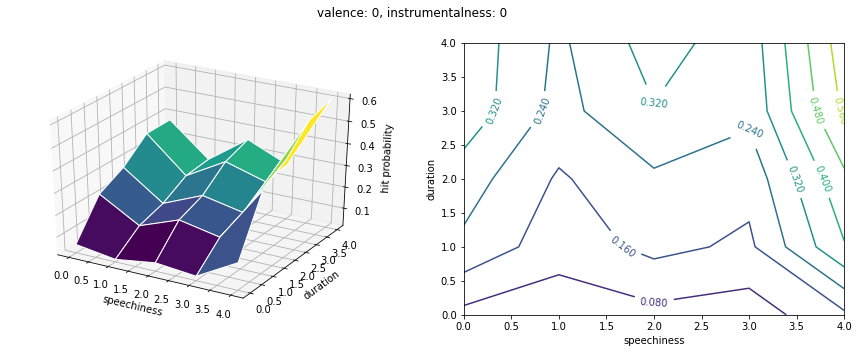

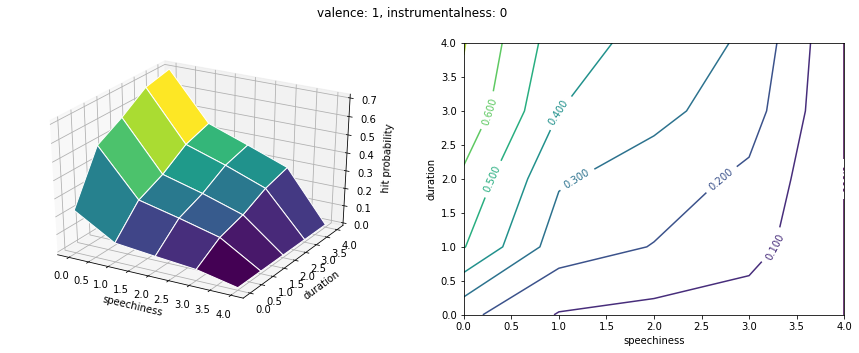

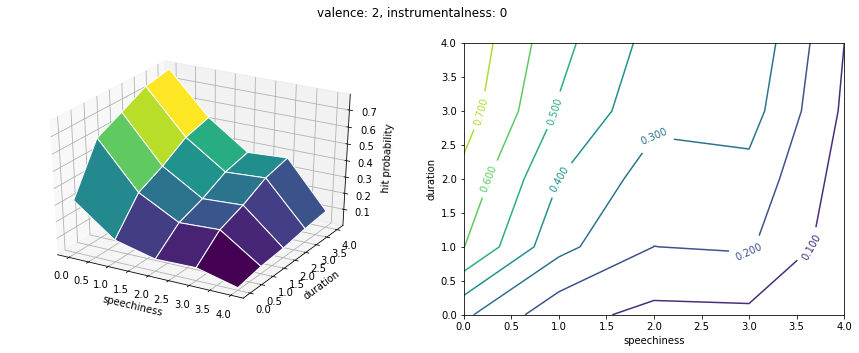

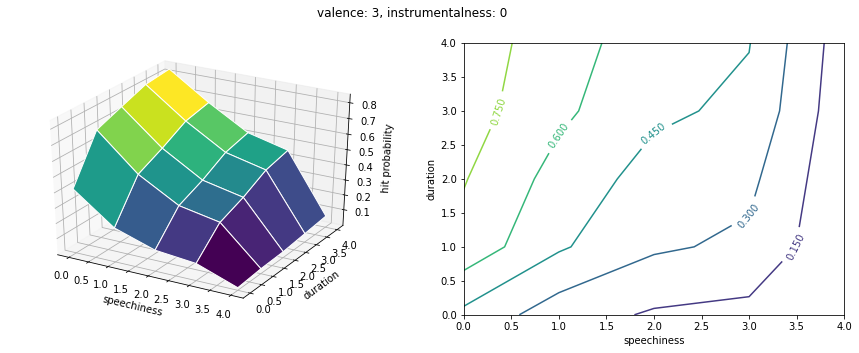

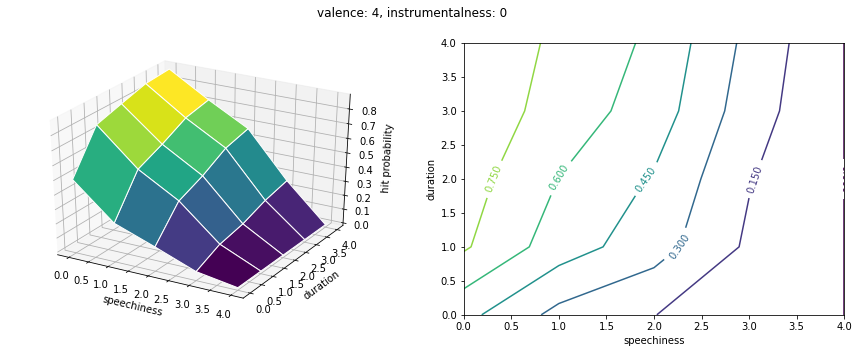

In [30]:
answers = [[[] for _ in range(5)] for _ in range(5)]
for valence in range(5):
  for duration in range(5):
    for speechiness in range(5):
      evidence = {"duration_ms": duration, "speechiness": speechiness, 'instrumentalness': 0, 'valence': valence}
      answers[valence][duration].append(ve.query(["On_chart"], evidence, show_progress=False).values[1])

for i in range(5):
  plot3d(range(5), range(5), np.array(answers[i]),
         'speechiness', 'duration', 'hit probability', f'valence: {i}, instrumentalness: 0')

What said for the previous model still holds, but now we can see that long tracks (last cinquile) have the highest probability.

### HC constrained model, with inverted arrows

In this model the features that directly influence On_chart are:
 - duration_ms, range {0,...,4},
 - instrumentalness, range {0,1},
 - speechiness, range {0,...,4},
 - valence, range {0,...,4}.
 - acousticness, range {0,...,4},
 - mode, range {0,1}

Let's see how they influence it.

In [37]:
ve = inferences['HC constraint model, with inverted arrows']
answers_duration = []
answers_instrumental = []
answers_speech = []
answers_valence = []
answers_acoustic = []
answers_mode = []
for score in range(5):
  for feature, answers in [('duration_ms', answers_duration),
                            ('speechiness', answers_speech),
                            ('valence', answers_valence),
                           ('acousticness', answers_acoustic)]:
    evidence = {feature : score}
    answers.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])
for score in range(2):
  evidence = {"instrumentalness": score}
  answers_instrumental.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])
  evidence = {'mode' : score}
  answers_mode.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])


[]

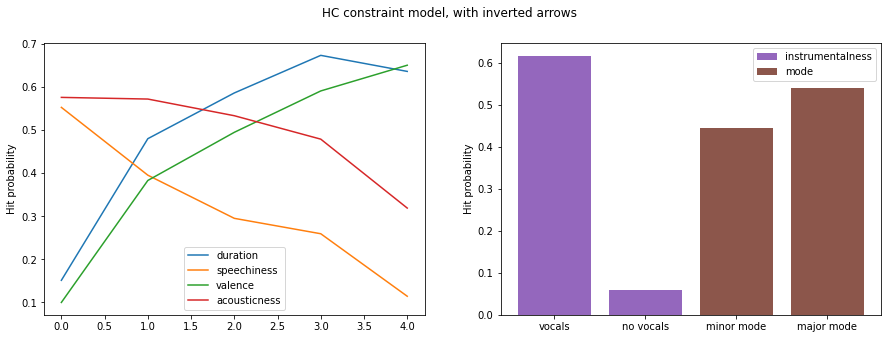

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"HC constraint model, with inverted arrows")
ax.set_ylabel('Hit probability')
ax.plot(answers_duration, label='duration')
ax.plot(answers_speech, label='speechiness')
ax.plot(answers_valence, label='valence')
ax.plot(answers_acoustic, label='acousticness')
ax.legend()
ax2 = axes[1]
ax2.bar(range(2), answers_instrumental, label='instrumentalness', color='C4')
ax2.bar(range(2,4), answers_mode, label='mode', color='C5')
ax2.legend()
ax2.set_xticks(range(4))
ax2.set_xticklabels(['vocals', 'no vocals', 'minor mode', 'major mode'])
ax2.set_ylabel('Hit probability')
plt.plot()

This model seems to sum up the other two models and also it tells us that major mode tracks have a bit more chance to be hits, but it semmes to be negligible.

We have only analyzed direct influence factors, but the generated models tell us also about other features, with a lot of possible combination. For example we could want to know if there is a best tempo to choose if we want to public on Spotify an angry (valence=0) metal (energy=4, loudness=4, acousticness=0, speechiness=0) song with vocals (instrumentalness=0) and we wanto it to become an hit. What if we want it to be danceable?

In [41]:
ve = inferences['HC constraint model, with inverted arrows']
answers_hit = []
answers_dance = []
for tempo in range(5):
  evidence = {'tempo': tempo, 'valence': 0, 'energy': 4, 'loudness': 4, 'acousticness': 0, 'speechiness': 0, 'instrumentalness': 0}
  answers_hit.append(ve.query(["On_chart"], evidence, show_progress=False).values[1])
  answers_dance.append(ve.query(["danceability"], evidence, show_progress=False).values)

[]

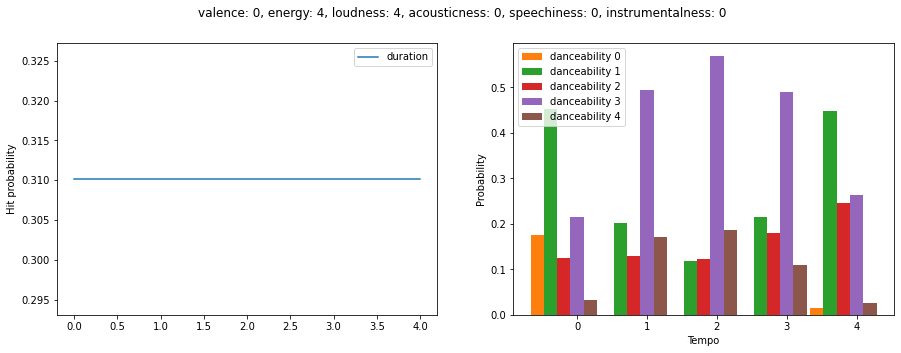

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
fig.suptitle(f"valence: 0, energy: 4, loudness: 4, acousticness: 0, speechiness: 0, instrumentalness: 0")
ax.set_ylabel('Hit probability')
ax.plot(answers_hit, label='duration')
ax.legend()
ax2 =axes[1]
for i in range(5):
  ax2.bar(np.arange(5) + (i-3)*0.19, list(map(lambda x: x[i], answers_dance)), 0.19, label=f"danceability {i}", color=f'C{i+1}')
ax2.legend()
ax2.set_xticks(range(5))
ax2.set_ylabel('Probability')
ax2.set_xlabel('Tempo')
plt.plot()

The answers is that there is not a best possible tempo to make the song a hit, since it is influent, but if we choose a tempo in the second cinquile at least we have the higest probability to make it danceable.